In [2]:
import os

import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### GATConv
Graph attention layer from Graph Attention Network
$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and
node $j$:

$$
\begin{align}\begin{aligned}\alpha_{ij}^{l} &= \mathrm{softmax_i} (e_{ij}^{l})\\e_{ij}^{l} &= 
\mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)\end{aligned}\end{align}
$$

这里的 $softmax_i$ 是对节点$i$的多个边进行归一化，不考虑其他边

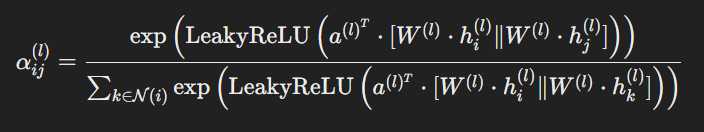

### 定义图

num of nodes 7
num of edges 12


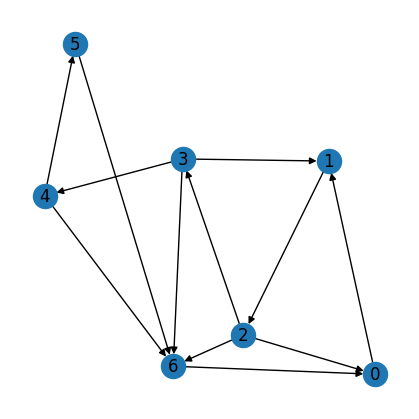

In [3]:
g = dgl.graph(([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 0]))
# g=dgl.add_reverse_edges(g)
g.add_edges([2, 3, 2, 3, 4], [0, 1, 6, 6, 6])
g.ndata["h"] = torch.FloatTensor(
    [
        [0, 0, 0, 0],  # 0
        [1, 1, 1, 1],  # 1
        [2, 2, 2, 2],  # 2
        [3, 3, 3, 3],  # 3
        [4, 4, 4, 4],  # 4
        [5, 5, 5, 5],  # 5
        [6, 6, 6, 6],  # 6
    ]
)
print("num of nodes", g.num_nodes())
print("num of edges", g.num_edges())
# g.edata["edge_weight"] = torch.FloatTensor([1,2,3,4,5])
# g.edata["edge_weight"] = torch.FloatTensor([1,2,3,4,5,6,7,8,9,10])


plt.figure(figsize=(4, 4))
nx.draw(dgl.to_networkx(g), with_labels=True)

以下度均为入度 <br>

0,1 节点有两个度 <br>

6 有 4个度

其余节点，4个节点度为1

### attention在reduce函数中实现

In [200]:
# W = torch.ones(4, 3)
# a = torch.ones(6, 1)


# def edge_attention(edges):
#     hi = edges.dst["h"]
#     hj = edges.src["h"]
#     hiW = hi @ W
#     hjW = hj @ W
#     h_cat = torch.cat([hiW, hjW], dim=1)
#     e = F.leaky_relu(h_cat @ a).squeeze()
#     alpha=F.softmax(e,dim=-1)
#     return {"alpha": alpha}


# with g.local_scope():
#     g.apply_edges(edge_attention)
#     hW = g.ndata["h"] @ W
#     # print(hW)
#     g.ndata["hW"] = hW
#     g.update_all(fn.u_mul_e("hW", "alpha", "hWe"), fn.sum("hWe", "h_N"))
#     h_N = g.dstdata["h_N"]
#     print(h_N)

In [216]:
W = torch.ones(4, 3)
a = torch.ones(6, 1)

from dgl.ops import edge_softmax


def edge_attention(edges):
    hi = edges.dst["h"]  # 来自目的节点
    hj = edges.src["h"]  # 来自源节点
    hiW = hi @ W
    hjW = hj @ W
    h_cat = torch.cat([hiW, hjW], dim=1)  # 拼接
    e = F.leaky_relu(h_cat @ a)
    return {"e": e}  # 将e放在边上


def msg_func(edges):
    # 将边上的e传递给目的节点，将特征h从源节点传递给目的节点特征z
    e = edges.data["e"]
    # print(edge_softmax(g,e))
    # print(dgl.nn.functional.edge_softmax(g,e))
    return {"z": edges.src["h"], "e": edges.data["e"]}


# 当所有节点的度（入度）不相同时，可能会返回多个tensor，如本图的结构
# 在聚合函数rdc_func中，print(e.shape)
# torch.Size([4, 1, 1])
# torch.Size([2, 2, 1])
# torch.Size([1, 4, 1])
# 说明4个节点度为1，2个节点度为2，1个节点度为4


def rdc_func(nodes):
    z = nodes.mailbox["z"]
    e = nodes.mailbox["e"]
    alpha = F.softmax(e, dim=1)
    azW = alpha * z @ W
    h_N = azW.sum(1)
    return {"h_N": h_N}


with g.local_scope():
    g.apply_edges(edge_attention)
    alpha = dgl.nn.functional.edge_softmax(g, g.edata["e"])
    g.update_all(msg_func, rdc_func)
    print(g.dstdata["h_N"])
    print(alpha)

tensor([[24.0000, 24.0000, 24.0000],
        [12.0000, 12.0000, 12.0000],
        [ 4.0000,  4.0000,  4.0000],
        [ 8.0000,  8.0000,  8.0000],
        [12.0000, 12.0000, 12.0000],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])
tensor([[2.3195e-16],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [9.9999e-01],
        [1.0000e+00],
        [1.4252e-21],
        [1.0000e+00],
        [2.3195e-16],
        [3.7751e-11],
        [6.1442e-06]])


### attention在reduce函数外，用edge_softmax实现

In [226]:
W = torch.ones(4, 3)
a = torch.ones(6, 1)

from dgl.ops import edge_softmax


def edge_attention(edges):
    hi = edges.dst["h"]  # 来自目的节点
    hj = edges.src["h"]  # 来自源节点
    hiW = hi @ W
    hjW = hj @ W
    h_cat = torch.cat([hiW, hjW], dim=1)  # 拼接
    e = F.leaky_relu(h_cat @ a)
    return {"e": e}  # 将e放在边上


with g.local_scope():
    g.apply_edges(edge_attention)
    alpha = dgl.nn.functional.edge_softmax(g, g.edata["e"])  # edge_softmax
    g.edata["alpha"] = alpha  # alpha即注意力权重

    g.ndata["hW"] = g.ndata["h"] @ W
    g.update_all(fn.u_mul_e("hW", "alpha", "m"), fn.sum("m", "hN"))  # 内置函数
    hN = g.ndata["hN"]
    print(hN)
    print(alpha)

tensor([[24.0000, 24.0000, 24.0000],
        [12.0000, 12.0000, 12.0000],
        [ 4.0000,  4.0000,  4.0000],
        [ 8.0000,  8.0000,  8.0000],
        [12.0000, 12.0000, 12.0000],
        [16.0000, 16.0000, 16.0000],
        [20.0000, 20.0000, 20.0000]])
tensor([[2.3195e-16],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [9.9999e-01],
        [1.0000e+00],
        [1.4252e-21],
        [1.0000e+00],
        [2.3195e-16],
        [3.7751e-11],
        [6.1442e-06]])


### DGL内置

In [227]:
from dgl.nn import GATConv

g = dgl.graph(([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 0]))
# g=dgl.add_reverse_edges(g)
g.add_edges([2, 3, 2, 3, 4], [0, 1, 6, 6, 6])
g.ndata["h"] = torch.FloatTensor(
    [
        [0, 0, 0, 0],  # 0
        [1, 1, 1, 1],  # 1
        [2, 2, 2, 2],  # 2
        [3, 3, 3, 3],  # 3
        [4, 4, 4, 4],  # 4
        [5, 5, 5, 5],  # 5
        [6, 6, 6, 6],  # 6
    ]
)

In [231]:
gat_conv = GATConv(4, 3, 1)

torch.nn.init.ones_(gat_conv.fc.weight)
torch.nn.init.ones_(gat_conv.attn_l)
torch.nn.init.ones_(gat_conv.attn_r)

print(gat_conv.fc.weight)
print(gat_conv.attn_l)
print(gat_conv.attn_r)

Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1.]]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1.]]], requires_grad=True)


In [232]:
h_l, att = gat_conv(g, g.ndata["h"], get_attention=True)

In [233]:
print(h_l.detach())
print(att.detach())

tensor([[[24.0000, 24.0000, 24.0000]],

        [[12.0000, 12.0000, 12.0000]],

        [[ 4.0000,  4.0000,  4.0000]],

        [[ 8.0000,  8.0000,  8.0000]],

        [[12.0000, 12.0000, 12.0000]],

        [[16.0000, 16.0000, 16.0000]],

        [[20.0000, 20.0000, 20.0000]]])
tensor([[[2.3195e-16]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[1.0000e+00]],

        [[9.9999e-01]],

        [[1.0000e+00]],

        [[1.4252e-21]],

        [[1.0000e+00]],

        [[2.3195e-16]],

        [[3.7751e-11]],

        [[6.1442e-06]]])
